### Unsupervised learning for clustering flower species together

A script to apply unsupervised learning to a dataset with different iris species to see if we can distinguish them.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
iris_data = pd.read_csv('../data/iris_data.csv')
iris_data.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']


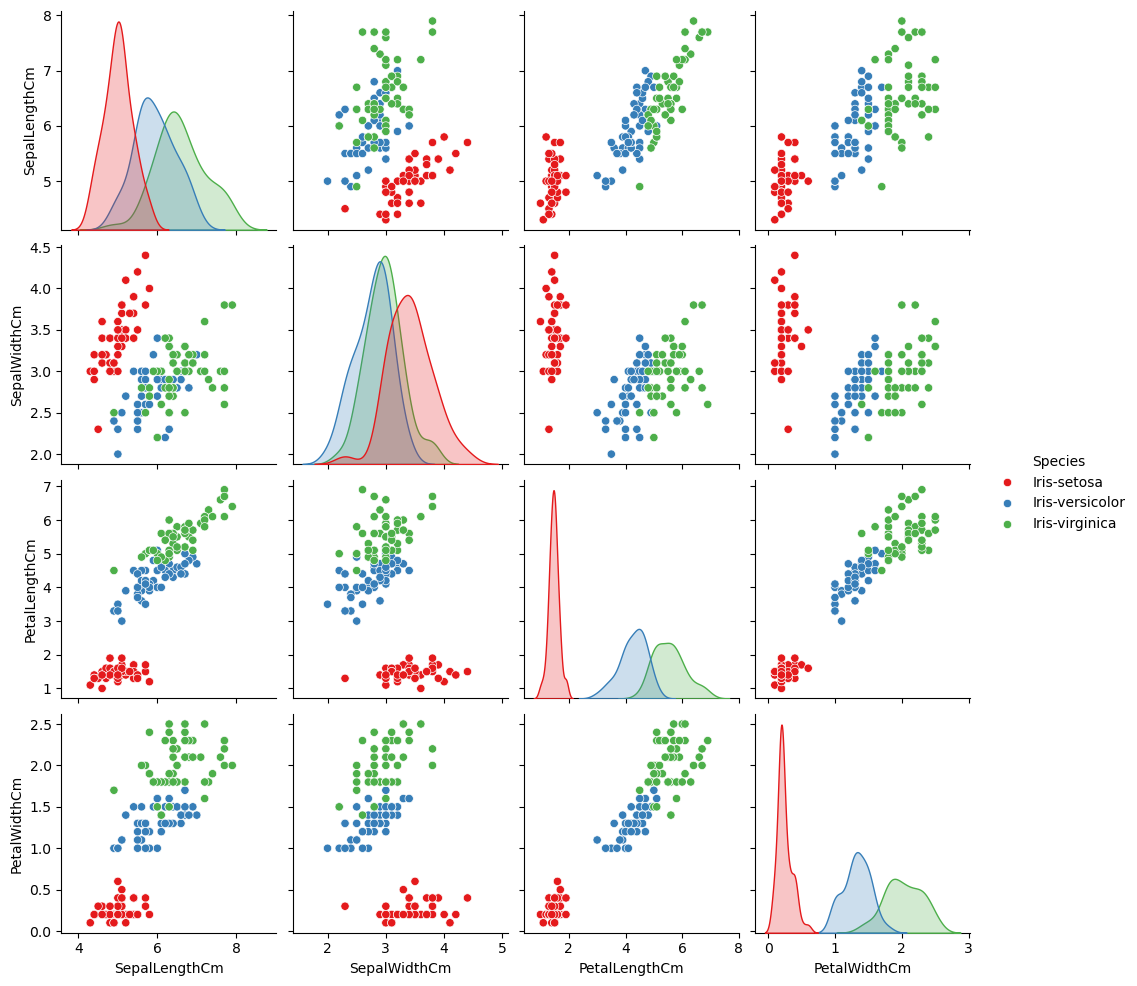

In [3]:
# There are 3 species in the dataset
print(iris_data['Species'].unique())

palette = sns.color_palette("Set1", n_colors=len(iris_data['Species'].unique()))

# Plot combinations of features with species as hue
sns.pairplot(iris_data, vars=['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm'], hue='Species', palette=palette)
plt.show()

Now we try to recreate something similar using clustering.

In [4]:
# Check for missing values
print(iris_data.isnull().sum())

Id               0
SepalLengthCm    0
SepalWidthCm     0
PetalLengthCm    0
PetalWidthCm     0
Species          0
dtype: int64


In [20]:
# Split data for training and validation (we can use the known labels for validation)
X = iris_data.drop(['Id', 'Species'], axis=1)
y = iris_data['Species']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
samples = X_train.values

# Standardize the features
scaler = StandardScaler()
scaled_samples = scaler.fit_transform(samples)

# Apply PCA
pca = PCA()
pca_scaled_samples = pca.fit_transform(scaled_samples)

In [31]:
# Define model with 3 clusters
model = KMeans(n_clusters=3)
model.fit(pca_scaled_samples)

# Predict the cluster labels
labels = model.predict(pca_scaled_samples)

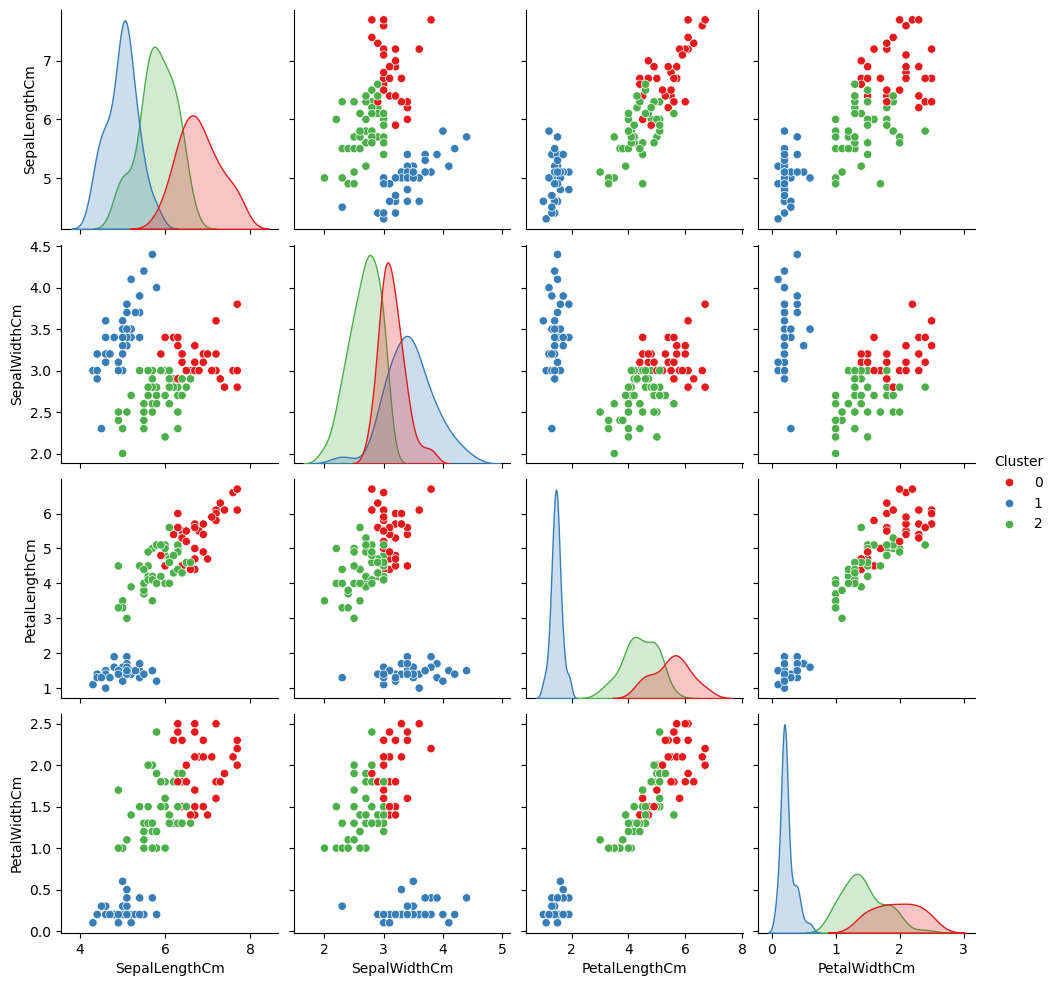

In [32]:
# Plot again with labels as hue
X_train['Cluster'] = labels
sns.pairplot(X_train, vars=['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm'], hue='Cluster', palette=palette)
plt.show()

In [33]:
# So the clustering works pretty well. The numbers correspond like this (it can change each run!):
mapping = {'Iris-versicolor':2, 'Iris-virginica':0, 'Iris-setosa':1}
X_train['Species_mapped'] = y_train.map(mapping)
X_train[['Cluster', 'Species_mapped']].head()	# Compare the clusters with the actual species

,Cluster,Species_mapped
22,1,1
15,1,1
65,0,2
11,1,1
42,1,1


In [34]:
# Then check how many we got right
correct = sum(X_train['Cluster'] == X_train['Species_mapped'])
total = len(X_train)
accuracy = correct / total
print(f'Accuracy: {100*accuracy:.2f}%')

Accuracy: 80.00%


Validation accuracy: 90.00%


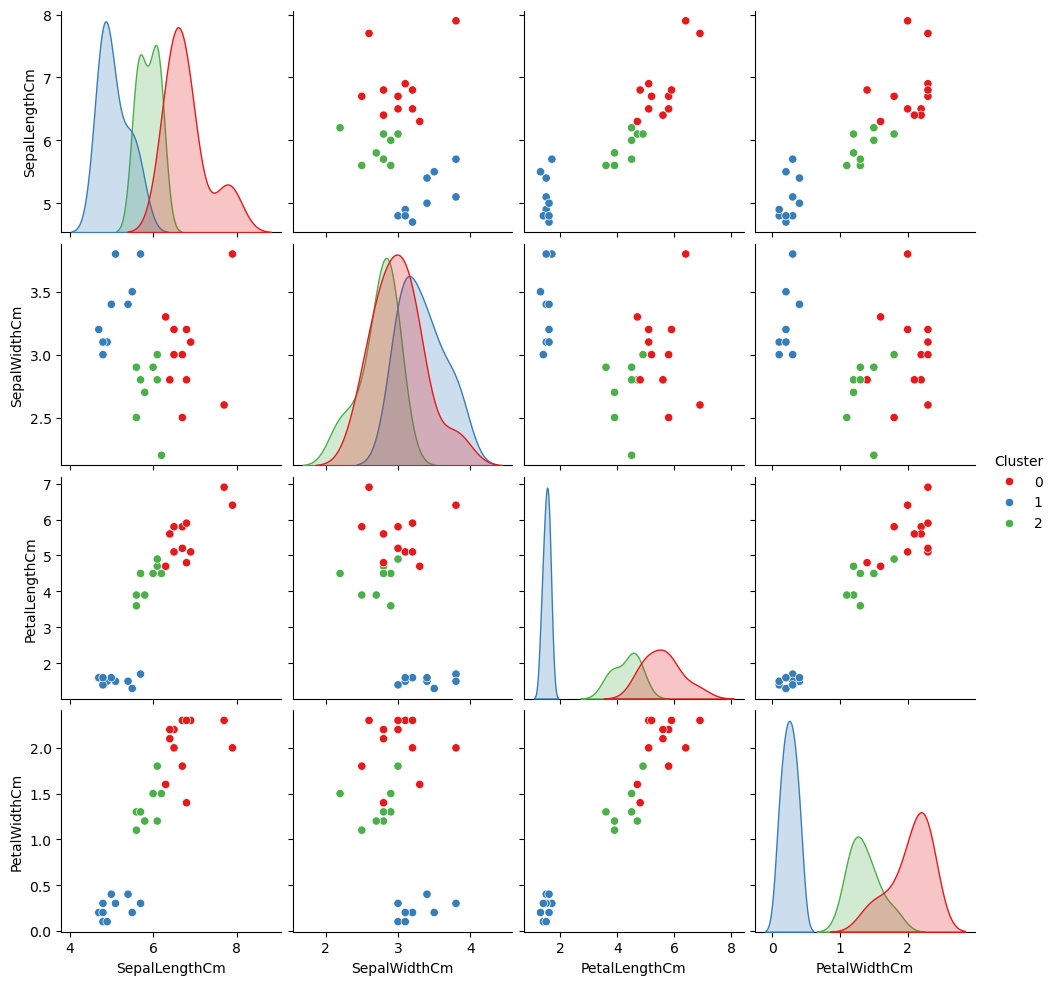

In [36]:
# Predict for the validation data
samples_valid = X_valid.values
scaled_samples_valid = scaler.transform(samples_valid)
pca_scaled_samples_valid = pca.transform(scaled_samples_valid)
labels_valid = model.predict(pca_scaled_samples_valid)

X_valid['Cluster'] = labels_valid
X_valid['Species_mapped'] = y_valid.map(mapping)
correct_valid = sum(X_valid['Cluster'] == X_valid['Species_mapped'])
total_valid = len(X_valid)
accuracy_valid = correct_valid / total_valid
print(f'Validation accuracy: {100*accuracy_valid:.2f}%')

# Plot the validation data
sns.pairplot(X_valid, vars=['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm'], hue='Cluster', palette=palette)
plt.show()

So on the validation data the model performs quite well too, thus it generalizes well. It even performs better on the validation than test data.

In [37]:
# Another way of evaluating the clustering is with the silhouette score, where we don't need the actual labels
silhouette = silhouette_score(pca_scaled_samples, labels)
print(f'Silhouette score: {silhouette:.2f}')

Silhouette score: 0.47


The silhouette score is quite poor (varying between -1 and 1, with 1 being best), especially given our high accuracy. It seems like geometrically speaking, the clusters are not separated enough to get a good score. We do see in the figures that certain points at the edges of each cluster overlap a bit, so that may be the cause.

In [38]:
# Also try the Davies-Bouldin score
db = davies_bouldin_score(pca_scaled_samples, labels)
print(f'Davies-Bouldin score: {db:.2f}')

Davies-Bouldin score: 0.82


This score also seems bad, as it should be as close to 0 as possible. Again this is likely due to the slight overlap of the clusters.